# Installations

In [ ]:
!pip install opencv-python

In [ ]:
!pip install -U albumentations

In [21]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.5 MB/s eta 0:00:00


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

# Dataset Download

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/A3_Dataset.zip', 'r') as p:
    p.printdir()
    print('Extracting all the files now...')
    p.extractall()

File Name                                             Modified             Size
A3_Dataset/                                    2021-11-16 16:26:24            0
A3_Dataset/dataset1/                           2017-09-22 22:20:16            0
A3_Dataset/dataset1/annotations_prepped_test/  2017-09-22 22:18:08            0
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png 2017-09-22 22:18:08         4774
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png 2017-09-22 22:18:08         4594
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png 2017-09-22 22:18:08         4817
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png 2017-09-22 22:18:08         4618
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png 2017-09-22 22:18:08         4477
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png 2017-09-22 22:18:08         4719
A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png 2017-09-22 22:18:08         4611
A3_Dataset/data

In [5]:
y_train_dir="/content/A3_Dataset/dataset1/annotations_prepped_train"
x_train_dir="/content/A3_Dataset/dataset1/images_prepped_train"
y_test_dir= "/content/A3_Dataset/dataset1/annotations_prepped_test"
x_test_dir="/content/A3_Dataset/dataset1/images_prepped_test"

# Dataset Loading

In [6]:
from scipy import io as sio

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [8]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        print(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        image =cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        mask=cv2.resize(mask,(320,320), interpolation = cv2.INTER_AREA)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [9]:
from keras import utils as np_utils

class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

In [10]:
import torch
# Lets look at data we have
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

In [11]:
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

['0006R0_f02220.png', '0016E5_05430.png', '0016E5_07230.png', '0016E5_06720.png', '0016E5_00690.png', '0016E5_06510.png', '0006R0_f03270.png', '0006R0_f03120.png', '0006R0_f03360.png', '0016E5_06780.png', '0016E5_08190.png', '0016E5_01050.png', '0016E5_01590.png', '0016E5_06330.png', '0016E5_01410.png', '0016E5_07620.png', '0006R0_f03060.png', '0006R0_f01260.png', '0001TP_007680.png', '0001TP_007740.png', '0006R0_f01560.png', '0006R0_f03630.png', '0016E5_08520.png', '0001TP_006690.png', '0001TP_008370.png', '0006R0_f01920.png', '0016E5_08640.png', '0001TP_007440.png', '0016E5_04560.png', '0016E5_00990.png', '0006R0_f01140.png', '0006R0_f01470.png', '0001TP_008280.png', '0006R0_f02070.png', '0006R0_f01800.png', '0016E5_05640.png', '0001TP_007560.png', '0006R0_f02280.png', '0016E5_05040.png', '0006R0_f03420.png', '0001TP_007140.png', '0016E5_06870.png', '0001TP_006810.png', '0016E5_05880.png', '0016E5_07560.png', '0016E5_01920.png', '0006R0_f01680.png', '0016E5_04440.png', '0006R0_f01710

In [12]:
image, mask = dataset[18] # get some sample
noclass=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in dataset:
  image, mask = i
  for j in range(0,12):
    count = np.count_nonzero(mask[:,:,j] == 1)
    noclass[j]=noclass[j]+count;
t=min(noclass)
newList = [sum(noclass) / (12*x) for x in noclass]
print(newList)
weight = []
for k in range(12):
  t=np.ndarray(shape=(320,320), dtype=float)
  for i in range(320):
    for j in range(320):
      t[i][j]=newList[0]
  weight.append(t)
weight = torch.Tensor(weight) 
print(weight.shape)

image, mask = dataset[250] # get some sample

[0.5206780719061339, 0.35857974909111795, 6.5473054526499475, 0.2599714067977797, 1.6778991542461017, 0.8864024234169798, 6.200715426549981, 5.955348828954232, 1.421328889260035, 11.794273089042042, 18.62741016109046, 2.5254386495440464]
torch.Size([12, 320, 320])


<ipython-input-12-115637a1f44b>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  weight = torch.Tensor(weight)


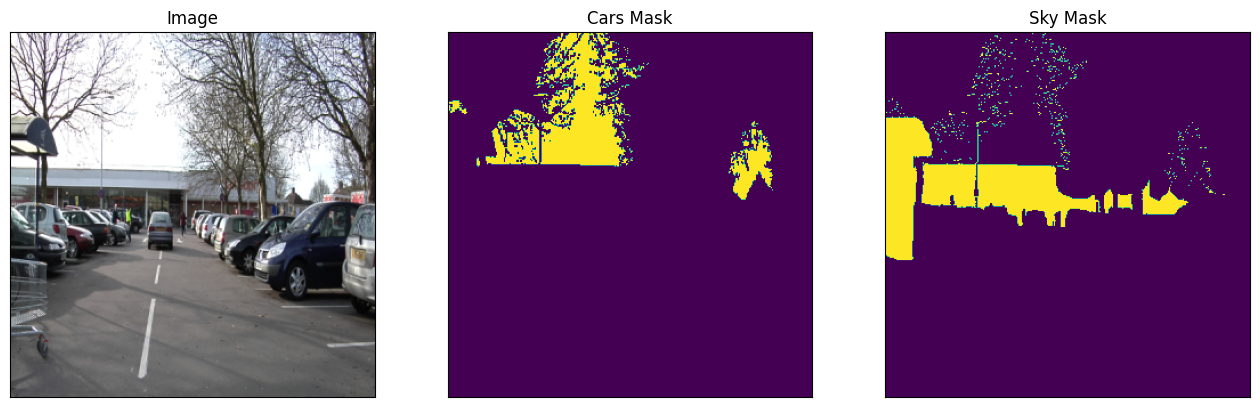

In [13]:
#print(mask)
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    #background_mask=mask[..., 2].squeeze(),
)

# using Albumentations for Augmentation


In [14]:
import albumentations as A
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

In [15]:
# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)

In [16]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

In [17]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [18]:
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

['0006R0_f02220.png', '0016E5_05430.png', '0016E5_07230.png', '0016E5_06720.png', '0016E5_00690.png', '0016E5_06510.png', '0006R0_f03270.png', '0006R0_f03120.png', '0006R0_f03360.png', '0016E5_06780.png', '0016E5_08190.png', '0016E5_01050.png', '0016E5_01590.png', '0016E5_06330.png', '0016E5_01410.png', '0016E5_07620.png', '0006R0_f03060.png', '0006R0_f01260.png', '0001TP_007680.png', '0001TP_007740.png', '0006R0_f01560.png', '0006R0_f03630.png', '0016E5_08520.png', '0001TP_006690.png', '0001TP_008370.png', '0006R0_f01920.png', '0016E5_08640.png', '0001TP_007440.png', '0016E5_04560.png', '0016E5_00990.png', '0006R0_f01140.png', '0006R0_f01470.png', '0001TP_008280.png', '0006R0_f02070.png', '0006R0_f01800.png', '0016E5_05640.png', '0001TP_007560.png', '0006R0_f02280.png', '0016E5_05040.png', '0006R0_f03420.png', '0001TP_007140.png', '0016E5_06870.png', '0001TP_006810.png', '0016E5_05880.png', '0016E5_07560.png', '0016E5_01920.png', '0006R0_f01680.png', '0016E5_04440.png', '0006R0_f01710

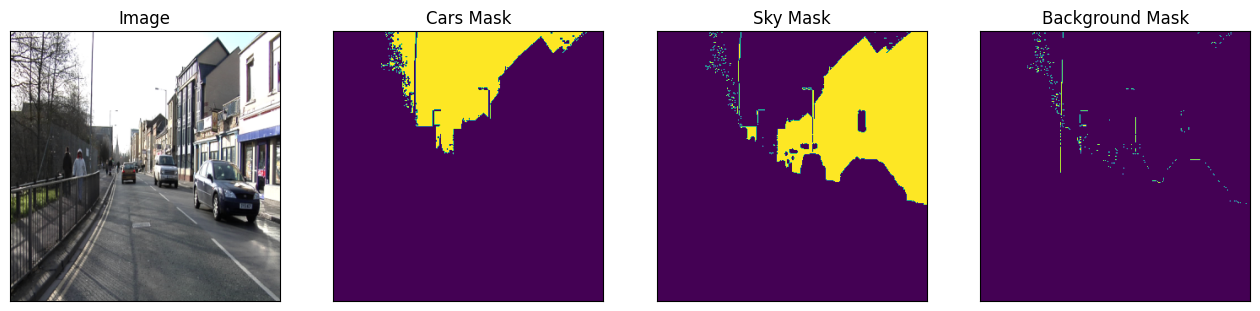

In [19]:
image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Segmentation Model - Training

In [22]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

sm.framework()

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [23]:
BACKBONE = 'resnet34'
BATCH_SIZE = 8
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol',
           'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [24]:
# define network parameters
n_classes=12
activation = 'sigmoid' if n_classes == 1 else 'softmax'
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

85521592/85521592 [==============================] - 1s 0us/step


In [25]:
import keras.backend as K
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [26]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [27]:
import tensorflow as tf
# define optomizer
optim = tf.keras.optimizers.Adam(LR)
print(newList)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

[0.5206780719061339, 0.35857974909111795, 6.5473054526499475, 0.2599714067977797, 1.6778991542461017, 0.8864024234169798, 6.200715426549981, 5.955348828954232, 1.421328889260035, 11.794273089042042, 18.62741016109046, 2.5254386495440464]


In [28]:
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sensitivity,specificity,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy']

In [29]:
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [30]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),

    )

['0006R0_f02220.png', '0016E5_05430.png', '0016E5_07230.png', '0016E5_06720.png', '0016E5_00690.png', '0016E5_06510.png', '0006R0_f03270.png', '0006R0_f03120.png', '0006R0_f03360.png', '0016E5_06780.png', '0016E5_08190.png', '0016E5_01050.png', '0016E5_01590.png', '0016E5_06330.png', '0016E5_01410.png', '0016E5_07620.png', '0006R0_f03060.png', '0006R0_f01260.png', '0001TP_007680.png', '0001TP_007740.png', '0006R0_f01560.png', '0006R0_f03630.png', '0016E5_08520.png', '0001TP_006690.png', '0001TP_008370.png', '0006R0_f01920.png', '0016E5_08640.png', '0001TP_007440.png', '0016E5_04560.png', '0016E5_00990.png', '0006R0_f01140.png', '0006R0_f01470.png', '0001TP_008280.png', '0006R0_f02070.png', '0006R0_f01800.png', '0016E5_05640.png', '0001TP_007560.png', '0006R0_f02280.png', '0016E5_05040.png', '0006R0_f03420.png', '0001TP_007140.png', '0016E5_06870.png', '0001TP_006810.png', '0016E5_05880.png', '0016E5_07560.png', '0016E5_01920.png', '0006R0_f01680.png', '0016E5_04440.png', '0006R0_f01710

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:386: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

In [31]:
# Dataset for validation images
valid_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
)

['0016E5_08073.png', '0016E5_08149.png', '0016E5_08017.png', '0016E5_08109.png', '0016E5_08057.png', '0016E5_08129.png', '0016E5_08065.png', '0016E5_07961.png', '0016E5_08077.png', '0016E5_08051.png', '0016E5_08011.png', '0016E5_07989.png', '0016E5_08041.png', '0016E5_08039.png', '0016E5_08005.png', '0016E5_08045.png', '0016E5_08049.png', '0016E5_08151.png', '0016E5_08069.png', '0016E5_08081.png', '0016E5_08145.png', '0016E5_08139.png', '0016E5_08047.png', '0016E5_07963.png', '0016E5_08009.png', '0016E5_08123.png', '0016E5_08025.png', '0016E5_08003.png', '0016E5_08085.png', '0016E5_08043.png', '0016E5_07977.png', '0016E5_08089.png', '0016E5_07997.png', '0016E5_08101.png', '0016E5_08111.png', '0016E5_07995.png', '0016E5_07979.png', '0016E5_07981.png', '0016E5_08061.png', '0016E5_08159.png', '0016E5_08099.png', '0016E5_08023.png', '0016E5_08121.png', '0016E5_08013.png', '0016E5_08103.png', '0016E5_07975.png', '0016E5_08131.png', '0016E5_08075.png', '0016E5_08119.png', '0016E5_08117.png',

In [32]:
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [33]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [34]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

<ipython-input-34-fc2eae185d4e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
45/45 [==============================] - 76s 771ms/step - loss: 0.9122 - sensitivity: 0.1410 - specificity: 0.9982 - iou_score: 0.0627 - f1-score: 0.0917 - accuracy: 0.3619 - val_loss: 0.8945 - val_sensitivity: 0.2804 - val_specificity: 0.9946 - val_iou_score: 0.1074 - val_f1-score: 0.1370 - val_accuracy: 0.4471 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - 30s 670ms/step - loss: 0.8087 - sensitivity: 0.4495 - specificity: 0.9960 - iou_score: 0.2028 - f1-score: 0.2484 - accuracy: 0.4971 - val_loss: 0.8316 - val_sensitivity: 0.4119 - val_specificity: 0.9932 - val_iou_score: 0.1457 - val_f1-score: 0.1695 - val_accuracy: 0.5386 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - 28s 619ms/step - loss: 0.7629 - sensitivity: 0.5244 - specificity: 0.9943 - iou_score: 0.2516 - f1-score: 0.3032 - accuracy: 0.4954 - val_loss: 0.7872 - val_sensitivity: 0.4884 - val_specificity: 0.9953 - val_iou_score: 0.2433 - val_f1-score: 0.2815 - val_accur

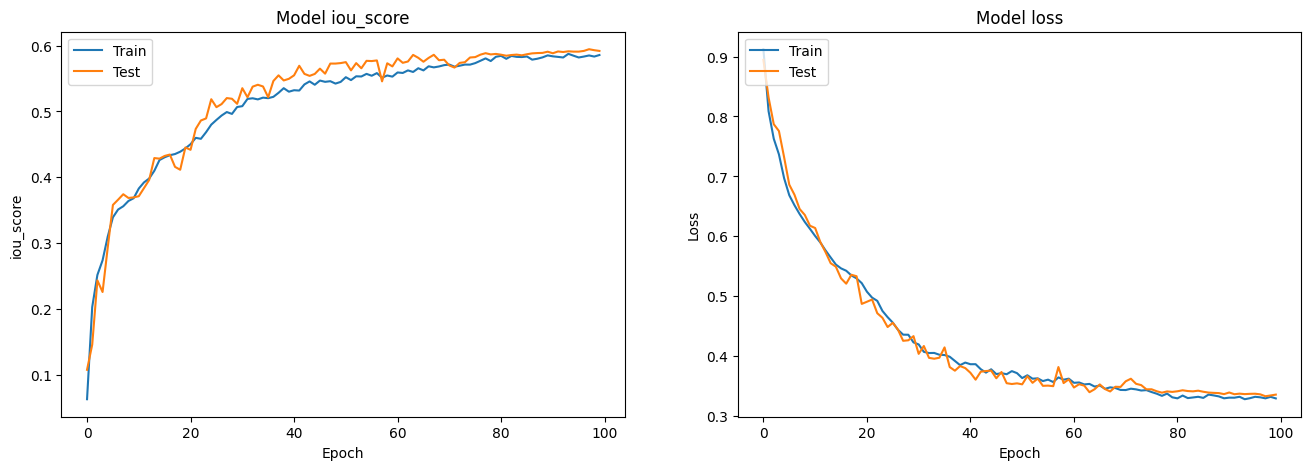

In [35]:
# Plot training & validation iou_score values
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Segmentation Model - Evaluation

In [36]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

['0016E5_08073.png', '0016E5_08149.png', '0016E5_08017.png', '0016E5_08109.png', '0016E5_08057.png', '0016E5_08129.png', '0016E5_08065.png', '0016E5_07961.png', '0016E5_08077.png', '0016E5_08051.png', '0016E5_08011.png', '0016E5_07989.png', '0016E5_08041.png', '0016E5_08039.png', '0016E5_08005.png', '0016E5_08045.png', '0016E5_08049.png', '0016E5_08151.png', '0016E5_08069.png', '0016E5_08081.png', '0016E5_08145.png', '0016E5_08139.png', '0016E5_08047.png', '0016E5_07963.png', '0016E5_08009.png', '0016E5_08123.png', '0016E5_08025.png', '0016E5_08003.png', '0016E5_08085.png', '0016E5_08043.png', '0016E5_07977.png', '0016E5_08089.png', '0016E5_07997.png', '0016E5_08101.png', '0016E5_08111.png', '0016E5_07995.png', '0016E5_07979.png', '0016E5_07981.png', '0016E5_08061.png', '0016E5_08159.png', '0016E5_08099.png', '0016E5_08023.png', '0016E5_08121.png', '0016E5_08013.png', '0016E5_08103.png', '0016E5_07975.png', '0016E5_08131.png', '0016E5_08075.png', '0016E5_08119.png', '0016E5_08117.png',

In [37]:
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [38]:
# load best weights
model.load_weights('best_model') 

In [39]:
scores = model.evaluate_generator(test_dataloader)

print(scores)

<ipython-input-39-d1d73de02d4e>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


[0.3205907940864563, 0.9142003059387207, 0.9925161600112915, 0.6095165610313416, 0.6985008120536804, 0.9151571393013]



# Visualization of Test Results

101
0
1/1 [==============================] - 2s 2s/step


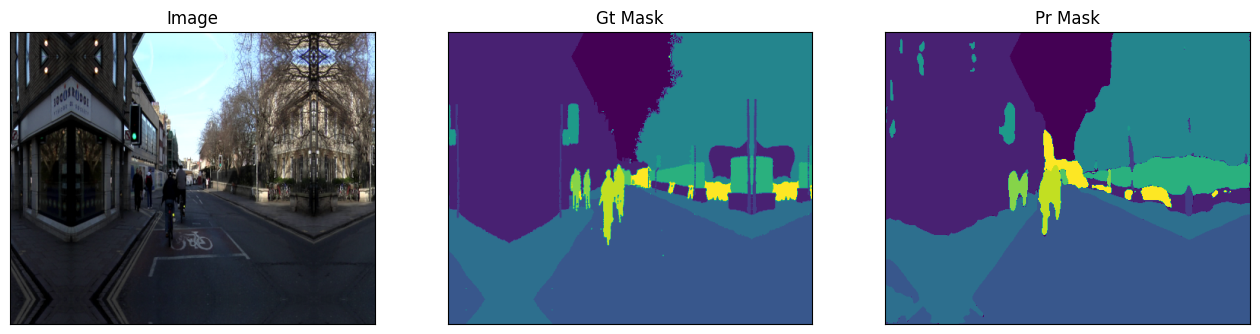

1
1/1 [==============================] - 0s 23ms/step


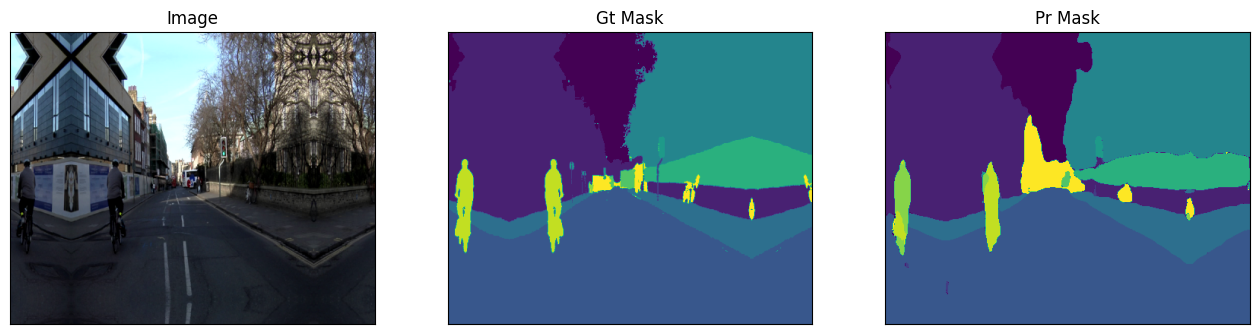

5
1/1 [==============================] - 0s 23ms/step


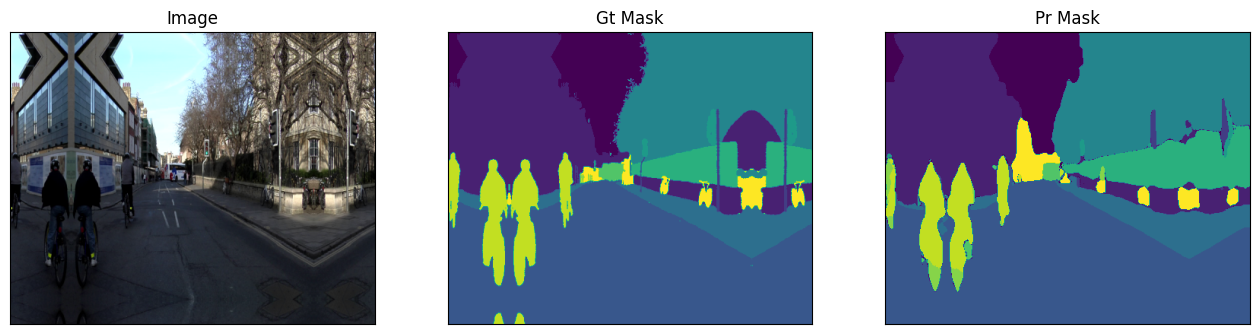

60
1/1 [==============================] - 0s 24ms/step


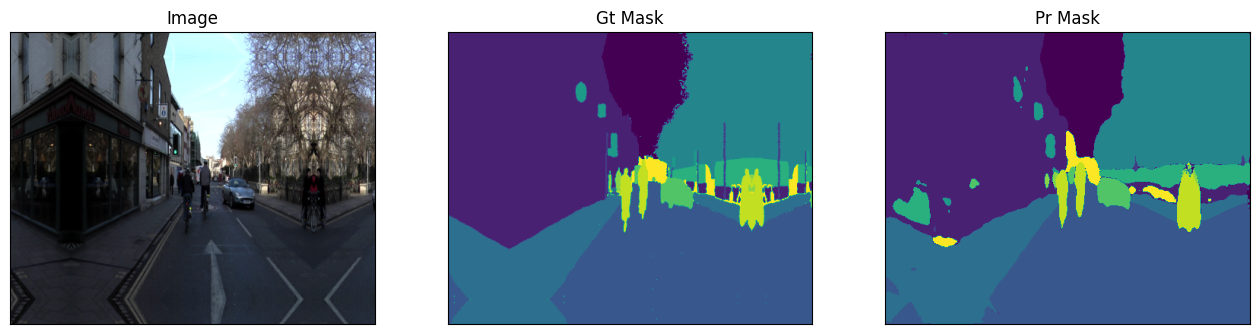

12
1/1 [==============================] - 0s 25ms/step


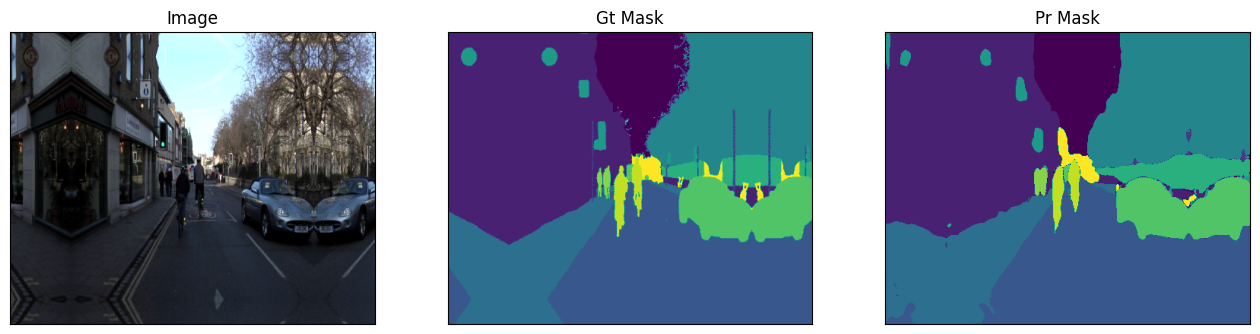

In [40]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
ids=[0,1,5,60,12]
print(len(test_dataset))
for i in ids:
    print(i)
    image, gt_mask = valid_dataset[i]
    gt_mask=np.argmax(gt_mask,axis=2) 
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    pr_mask=np.argmax(pr_mask,axis=3) 
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(0),
    )

1/1 [==============================] - 1s 1s/step


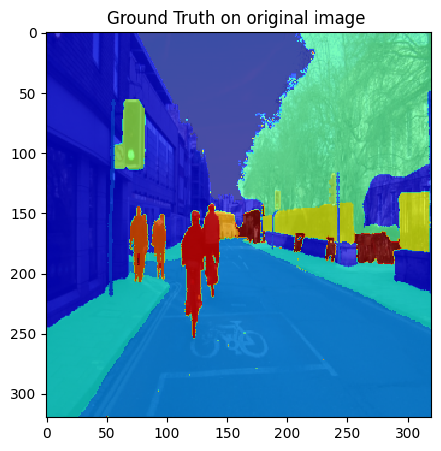

In [41]:
image, gt_mask = test_dataset[100]
gt_mask=np.argmax(gt_mask,axis=2) 
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image).round()
pr_mask=np.argmax(pr_mask,axis=3) 
   
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.imshow(image.squeeze(), interpolation='none')
plt.imshow(gt_mask.squeeze(), 'jet', interpolation='none', alpha=0.7)
plt.title("Ground Truth on original image ")

#plt.subplot(1,2,2)
#plt.imshow(image.squeeze(), 'gray', interpolation='none')
#plt.imshow(pr_mask.squeeze(0), 'jet', interpolation='none', alpha=0.7)
#plt.title("Predicted Truth on original image")

plt.show()